<img src="https://climate.nasa.gov/rails/active_storage/blobs/redirect/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbjhxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--4991bee2efb16c12caca6f535e504ce7a99b0f1c/epic_fires_header_0.gif" alt="The Earth Polychromatic Imaging Camera, or EPIC, captured this image of smoke from a wildfire in North America on Aug.15, 2018. Credit: NASA Goddard/ Katy Mersmann"></img>

# Great Circles and a Point

---

## Overview
A plane traveling across the country suddenly discovers it is low on fuel! It can no longer make it to the distant planned airport, instead it has to find the closest airport to its current position that it can make it with its remaining fuel

1. Determine the distance of a point to a great circle arc
1. Determine the distance of a point to a great circle path
1. Determine if a point lies on a great circle arc and path (with/without tolerances)

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Pandas](https://foundations.projectpythia.org/core/numpy.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Will be used for plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful | Will be used for plotting |


- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.

---

In [65]:
import pandas as pd

In [66]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.index = location_df["name"]
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
name,,,,,,,,,,,,
arecibo,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-0.872119,0.374643,0.314723
boulder,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-0.738835,-0.201714,0.642988
boston,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-0.698914,0.239852,0.673788
red woods,red woods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-0.621549,-0.419898,0.661334
houston,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-0.866469,-0.077303,0.493210


## Determine the distance of a point to a great circle arc

- Cross track distance: angular distance from point P to great circle path
- Along track distance: angular distance along the great circle path from A to B before hitting a point that is closest to point P

Cross-Track Distance, sometimes known as cross track error, can also be determined with vectors (typically simpler too)

### Cross Track Distance
Distance of a point to a great circle arc

```
dxt = asin( sin(δ13) ⋅ sin(θ13−θ12) ) * R
```
- δ13 (delta_13) is (angular) distance from start point to third point
- θ13 (theta_13) is (initial) bearing from start point to third point
- θ12 (theta_12) is (initial) bearing from start point to end point
- R is the earth’s radius

```
d_xt = np.arcsin(np.sin(delta_13)*np.sin(theta_13 - theta_12)) * R
```
```
XTD =asin(sin(dist_AD)*sin(crs_AD-crs_AB))
```
> positive XTD means right of course, negative means left

> If the point A is the N. or S. Pole replace crs_AD-crs_AB with 
lon_D-lon_B or lon_B-lon_D, respectively
 
### Along Track Distance

```
dat = acos( cos(δ13) / cos(δxt) ) * R
```
- δ13 (delta_13) is (angular) distance from start point to third point
- δxt (delta_xt) is (angular) cross-track distance
- R is the earth’s radius

```
d_at = np.arccos(np.cos(delta_13)/np.cos(d_xt/R)) * R
```
```
ATD=acos(cos(dist_AD)/cos(XTD))
```
>  For very short distances (is less susceptible to rounding error):
```
ATD=asin(sqrt( (sin(dist_AD))^2 - (sin(XTD))^2 )/cos(XTD))
```
References:
- [Aviation Formulary V1.47](https://edwilliams.org/avform147.htm)
- [Moveable Type Script](https://www.movable-type.co.uk/scripts/latlong.html)

In [67]:
import numpy as np

import geopy.distance

import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

from pyproj import Geod
geodesic = Geod(ellps="WGS84")
earth_radius = 6378137  # meters

In [81]:
def cross_track_distance(start_point=None, end_point=None, new_point=None):
    fwd_bearing_start_end, _, _ = geodesic.inv(location_df.loc[[start_point]]["longitude"].iloc[0],
                                               location_df.loc[[start_point]]["latitude"].iloc[0], 
                                               location_df.loc[[end_point]]["longitude"].iloc[0],
                                               location_df.loc[[end_point]]["latitude"].iloc[0])
    fwd_bearing_start_new, _, distance_m_start_new = geodesic.inv(location_df.loc[[start_point]]["longitude"].iloc[0],
                                                                  location_df.loc[[start_point]]["latitude"].iloc[0], 
                                                                  location_df.loc[[new_point]]["longitude"].iloc[0],
                                                                  location_df.loc[[new_point]]["latitude"].iloc[0]) 

    angular_distance_start_new = distance_m_start_new / earth_radius
    ct_distance = np.arcsin(np.sin(angular_distance_start_new) * np.sin(np.deg2rad(fwd_bearing_start_new - fwd_bearing_start_end))) * earth_radius
    return ct_distance

In [89]:
def along_track_distance(start_point=None, end_point=None, new_point=None):
    crosst_distance = cross_track_distance(start_point, end_point, new_point)

    _, _, distance_m_start_new = geodesic.inv(location_df.loc[[start_point]]["longitude"].iloc[0],
                                              location_df.loc[[start_point]]["latitude"].iloc[0], 
                                              location_df.loc[[new_point]]["longitude"].iloc[0],
                                              location_df.loc[[new_point]]["latitude"].iloc[0])  
    angular_distance_start_new = distance_m_start_new / earth_radius
    at_distance = np.arccos(np.cos(angular_distance_start_new) / np.cos(crosst_distance / earth_radius)) * earth_radius
    return at_distance

In [90]:
# Distance point along great circle path
def point_along_path(start_point=None, end_point=None, distance_m=None):
    fwd_bearing, _, _ = geodesic.inv(location_df.loc[[start_point]]["longitude"].iloc[0],
                                    location_df.loc[[start_point]]["latitude"].iloc[0], 
                                    location_df.loc[[end_point]]["longitude"].iloc[0],
                                    location_df.loc[[end_point]]["latitude"].iloc[0])  
    origin = geopy.Point(location_df.loc[[start_point]]["latitude"].iloc[0],
                         location_df.loc[[start_point]]["longitude"].iloc[0])
    distance_to_move = geopy.distance.distance(
                            kilometers=distance_m / 1000)  # distance to move towards the next point
    final_position = distance_to_move.destination(origin, bearing=fwd_bearing)
    return (final_position.latitude, final_position.longitude)

In [91]:
def interpolate_points_along_gc(lat_start,
                                lon_start,
                                lat_end,
                                lon_end,
                                distance_between_points_meter): 
    lat_lon_points = [(lat_start, lon_start)]
    
    # move to next point when distance between points is less than the equal distance
    move_to_next_point = True
    while(move_to_next_point):
        forward_bearing, reverse_bearing, distance_meters = geodesic.inv(lon_start,
                                                                         lat_start, 
                                                                         lon_end,
                                                                         lat_end)
        if distance_meters < distance_between_points_meter:
            # ends before overshooting
            move_to_next_point = False
        else:
            start_point = geopy.Point(lat_start, lon_start)
            distance_to_move = geopy.distance.distance(
                            kilometers=distance_between_points_meter /
                            1000)  # distance to move towards the next point
            final_position = distance_to_move.destination(
                            start_point, bearing=forward_bearing)
            lat_lon_points.append((final_position.latitude, final_position.longitude))
            # new starting position is newly found end position
            lon_start, lat_start = final_position.longitude, final_position.latitude
    lat_lon_points.append((lat_end, lon_end))
    return lat_lon_points

def arc_points(start_lat=None,
               start_lon=None,
               end_lat=None,
               end_lon=None,
               n_total_points=10):
    _, _, distance_meter =  geodesic.inv(start_lon,
                                        start_lat,
                                        end_lon,
                                        end_lat)
        
    distance_between_points_meter = distance_meter / (n_total_points + 1)

    
    new_points_lst = interpolate_points_along_gc(start_lat,
                                              start_lon,
                                              end_lat,
                                              end_lon,
                                              distance_between_points_meter)
    return new_points_lst

In [99]:
def plot_cross_track(start_point=None, end_point=None,
                     new_point=None,
                     closest_point=None,
                     cross_track_distance=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -130, -60, 20, 60
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")
    
    # Plot Latitude/Longitude Location
    great_circle_arc_pts = arc_points(location_df.loc[[start_point]]["latitude"].iloc[0],
                                         location_df.loc[[start_point]]["longitude"].iloc[0],
                                         location_df.loc[[end_point]]["latitude"].iloc[0],
                                         location_df.loc[[end_point]]["longitude"].iloc[0],
                                         10)
    longitudes = [x[1] for x in great_circle_arc_pts] # longitude
    latitudes = [x[0] for x in great_circle_arc_pts] # latitude
    plt.plot(longitudes, latitudes, c="purple")
    plt.scatter(longitudes, latitudes, c="purple")

    new_point_arc_pts = arc_points(closest_point[0],
                                   closest_point[1],
                                   location_df.loc[[new_point]]["latitude"].iloc[0],
                                   location_df.loc[[new_point]]["longitude"].iloc[0],
                                   10)
    longitudes = [x[1] for x in new_point_arc_pts] # longitude
    latitudes = [x[0] for x in new_point_arc_pts] # latitude
    plt.plot(longitudes, latitudes, c="green")
    plt.scatter(longitudes, latitudes, c="green")

    # plot closest_point in red
    plt.scatter(closest_point[1], closest_point[0], c="red")

    plt.title(f"Closest Point to Arc from {start_point.title()}->{end_point.title()} to {new_point.title()}, Cross-Track Distance = {cross_track_distance} km")
    plt.show()

Cross Track Distance: 
1341307.1776131338 meters (1341.3071776131337 km)
Along Track Distance: 
643895.2891543384 meters (643.8952891543385 km)

Closest Point To Point Along Great Circle Path:
(41.42753202293845, -97.8762203127258)


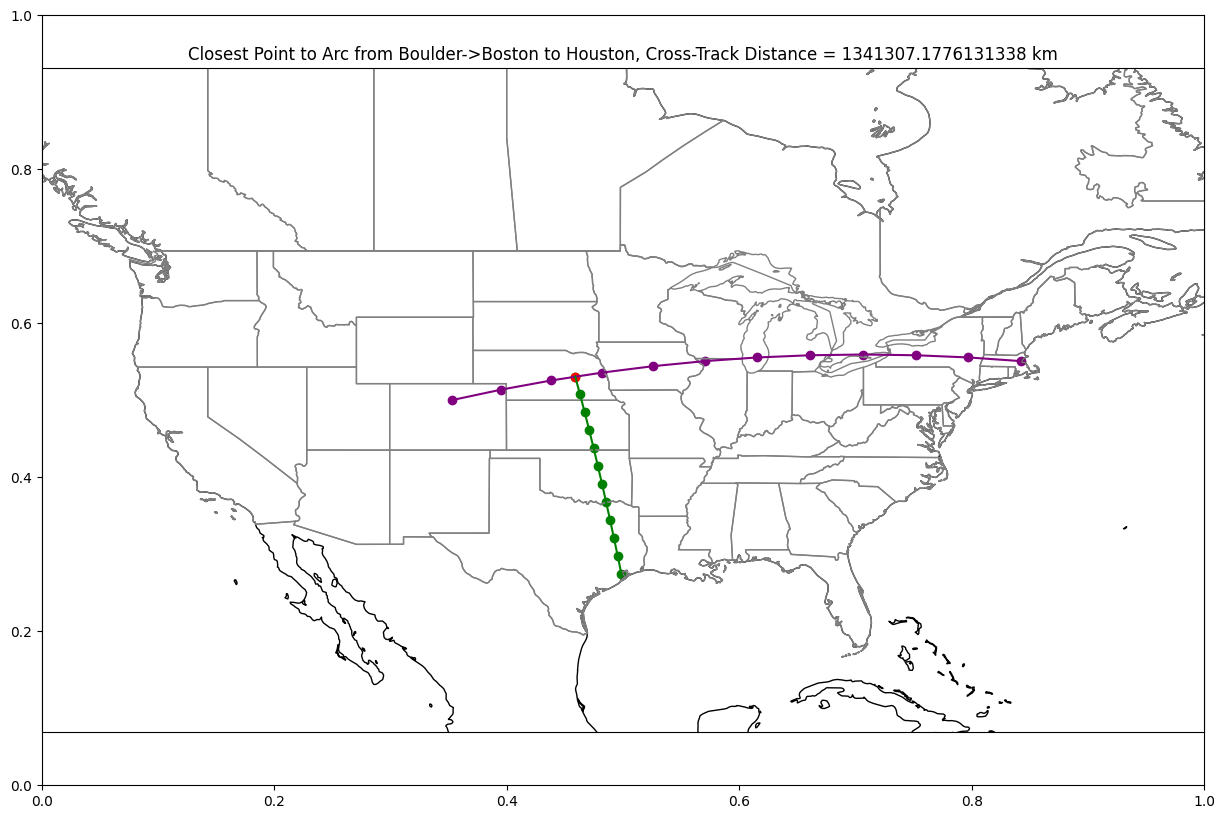

In [100]:
ct_distance = cross_track_distance("boulder", "boston", "houston")
print(f"Cross Track Distance: \n{ct_distance} meters ({ct_distance/1000} km)")

at_distance = along_track_distance("boulder", "boston", "houston")
print(f"Along Track Distance: \n{at_distance} meters ({at_distance/1000} km)\n")

closest_point = point_along_path("boulder", "boston", at_distance)
print(f"Closest Point To Point Along Great Circle Path:\n{closest_point}") 

plot_cross_track(start_point="boulder", end_point="boston",
                 new_point="houston", 
                 closest_point=closest_point, cross_track_distance=ct_distance)

Cross Track Distance: 
1593669.5260947915 meters (1593.6695260947915 km)
Along Track Distance: 
2076501.5510165778 meters (2076.5015510165777 km)

Closest Point To Point Along Great Circle Path:
(42.7552524575549, -80.62124342116076)


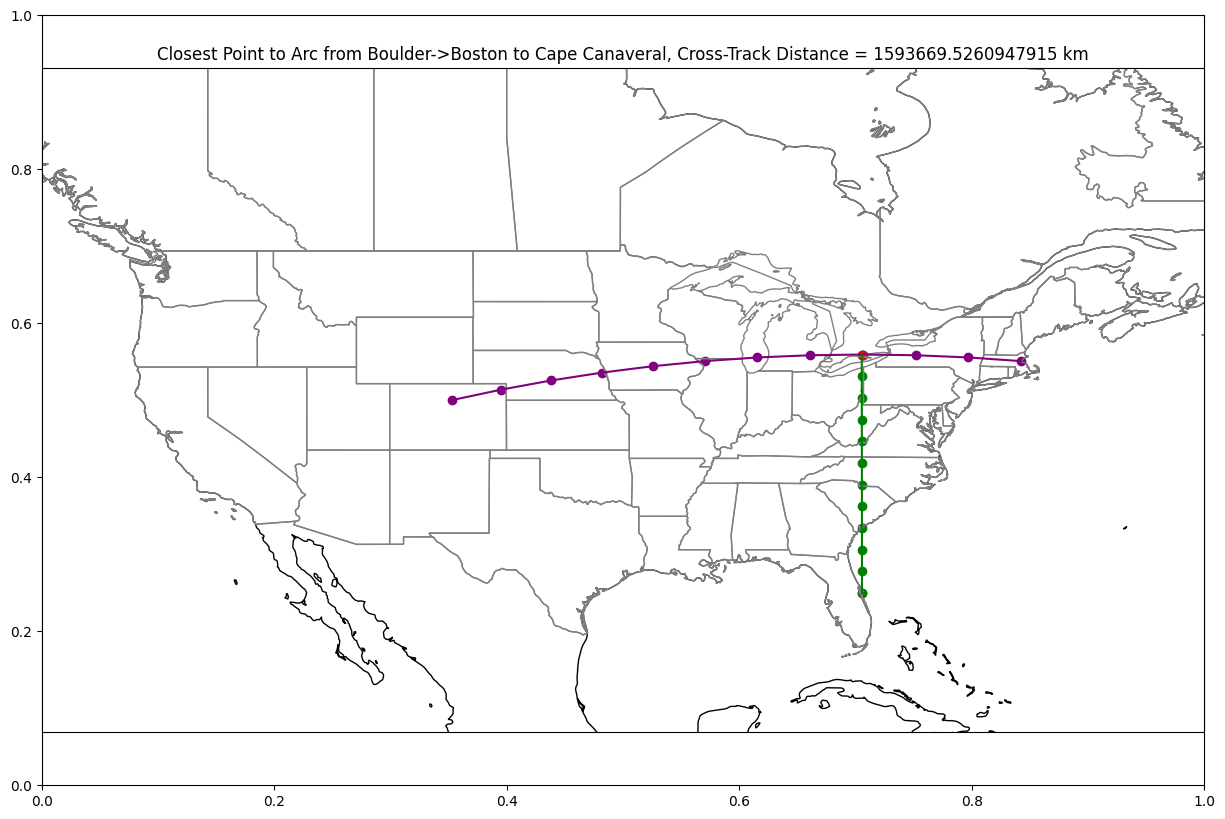

In [102]:
ct_distance = cross_track_distance("boulder", "boston", "cape canaveral")
print(f"Cross Track Distance: \n{ct_distance} meters ({ct_distance/1000} km)")

at_distance = along_track_distance("boulder", "boston", "cape canaveral")
print(f"Along Track Distance: \n{at_distance} meters ({at_distance/1000} km)\n")

closest_point = point_along_path("boulder", "boston", at_distance)
print(f"Closest Point To Point Along Great Circle Path:\n{closest_point}") 

plot_cross_track(start_point="boulder", end_point="boston",
                 new_point="cape canaveral", 
                 closest_point=closest_point, cross_track_distance=ct_distance)

---

## Summary
Calculating and plotting the cross-track and along-trackd distance of a great circle arc/path and a point

### What's next?

Determine when a great circle path crosses a given parallel and the maximum and minimum latitude coordinates of a great circle path

## Resources and references